In [1]:
import numpy as np
import pandas as pd
import sklearn
import os

In [2]:
DATA_NAME = 'train_r1.zip'
DATA_SUBDIR = '../data'
DATA_PATH = os.path.join(DATA_SUBDIR, DATA_NAME)

Read the data and take a look

In [45]:
data = pd.read_csv(DATA_PATH, compression='zip')
data.head()

,altura,exposicion,inclinacion_suelo,distancia_agua,altura_agua,distancia_caminos,sombra_maniana,sombra_mediodia,sombra_tarde,distancia_fuego,clase_area_silvestre,clase_suelo,dosel_forestal
0,2596,51,3,258,0,510,221,232,148,6279,1,29,5
1,2804,139,9,268,65,3180,234,238,135,6121,1,12,2
2,2785,155,18,242,118,3090,238,238,122,6211,1,30,2
3,2595,45,2,153,-1,391,220,234,150,6172,1,29,5
4,2579,132,6,300,-15,67,230,237,140,6031,1,29,2


Let's get some more information about the features 

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 464810 entries, 0 to 464809
Data columns (total 13 columns):
 #   Column                Non-Null Count   Dtype
---  ------                --------------   -----
 0   altura                464810 non-null  int64
 1   exposicion            464810 non-null  int64
 2   inclinacion_suelo     464810 non-null  int64
 3   distancia_agua        464810 non-null  int64
 4   altura_agua           464810 non-null  int64
 5   distancia_caminos     464810 non-null  int64
 6   sombra_maniana        464810 non-null  int64
 7   sombra_mediodia       464810 non-null  int64
 8   sombra_tarde          464810 non-null  int64
 9   distancia_fuego       464810 non-null  int64
 10  clase_area_silvestre  464810 non-null  int64
 11  clase_suelo           464810 non-null  int64
 12  dosel_forestal        464810 non-null  int64
dtypes: int64(13)
memory usage: 46.1 MB


There are 13 features, all of them already have numerical values and there are no `NA`s (yei!!). `clase_area_silvestre` and `clas_suelo` seem to be categorical features as well as `dosel_forestal` that is the target in this case.

In [31]:
data['dosel_forestal'].value_counts()

2    226596
1    169395
3     28602
7     16406
6     13993
5      7614
4      2204
Name: dosel_forestal, dtype: int64

In [32]:
data['clase_area_silvestre'].value_counts()


1    208660
3    202462
4     29683
2     24005
Name: clase_area_silvestre, dtype: int64

In [33]:
data.clase_suelo.value_counts()

29    92174
23    46126
32    42112
33    35990
22    26659
10    26247
30    24066
12    24034
31    20378
24    17146
13    13964
38    12448
39    11008
11     9939
4      9915
20     7430
40     7028
2      6004
6      5285
3      3870
19     3203
17     2756
1      2426
16     2292
26     2081
35     1538
18     1513
34     1289
5      1281
9       934
27      842
28      742
21      663
14      476
25      371
37      241
8       150
36      101
7        85
15        3
Name: clase_suelo, dtype: int64

In [34]:
data['clase_suelo'].value_counts().shape

(40,)

In [36]:
np.sort(data['clase_suelo'].unique())

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40])

## Split training and testing data

In [46]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(data, train_size=0.8, random_state=1234)

# Save testing data to a pickle
test_set.to_pickle(os.path.join(DATA_SUBDIR, 'test.pkl'))

# Rename data
data = train_set

The data is supposed to hace observations made on 30 m by 30 m spacial cells that contain different kids of trees, but I don't see a clear hint on how any of the features correspond to a position on the grid. So I'll go directly to see some information about the columns.

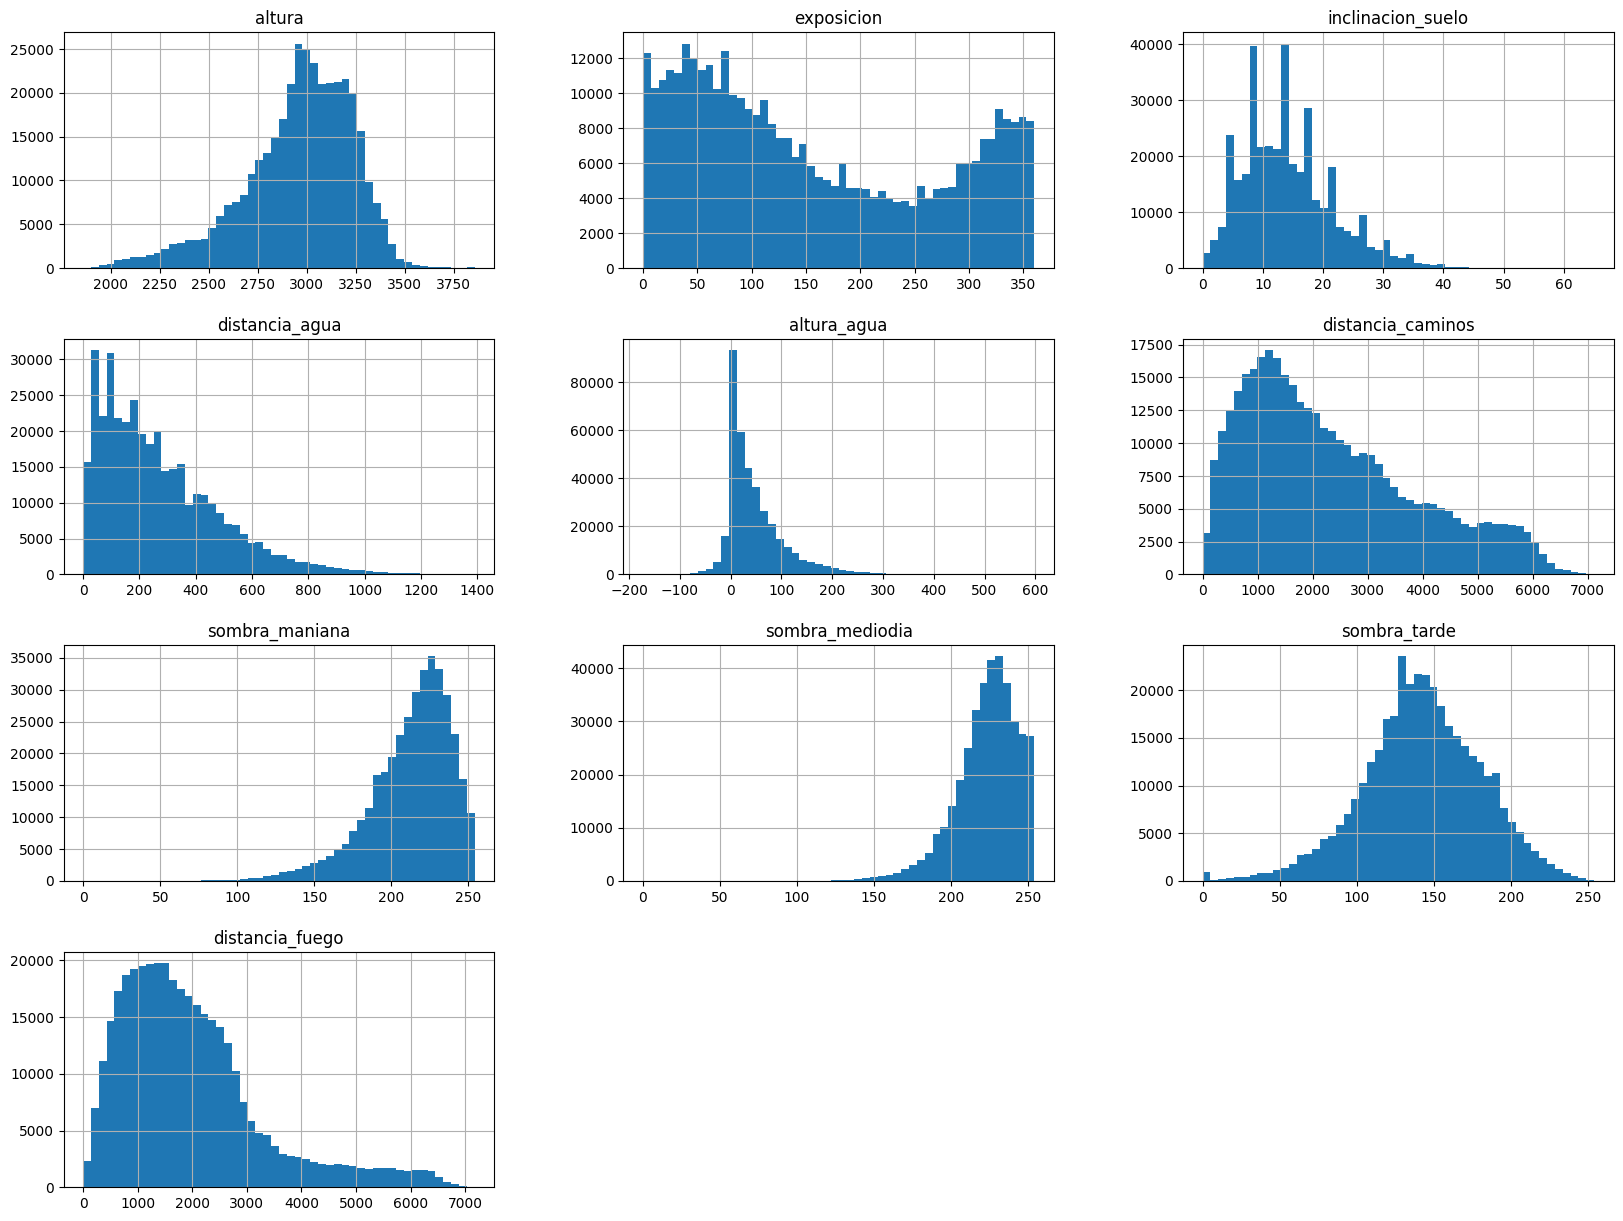

In [46]:
# Excluding categorical columns
data.drop(['dosel_forestal', 'clase_suelo', 'clase_area_silvestre'], axis=1).hist(bins=50, figsize=(20,15));

Not much information is gained from the previous distributions, let's better see the correlations between the features and the target

In [49]:
corr_matrix = data.corr()
corr_matrix['dosel_forestal'].sort_values(ascending=False)

dosel_forestal          1.000000
clase_area_silvestre    0.276797
inclinacion_suelo       0.148559
altura_agua             0.080721
exposicion              0.017218
distancia_agua         -0.021787
sombra_maniana         -0.036094
sombra_tarde           -0.048040
sombra_mediodia        -0.097080
distancia_fuego        -0.108859
distancia_caminos      -0.153657
clase_suelo            -0.165768
altura                 -0.271345
Name: dosel_forestal, dtype: float64

The features that are more correlated to the feature are `clase_area_silvestre`, `altura`, `clase_suelo`, `distancia_caminos` and `inclinacion_suelo`

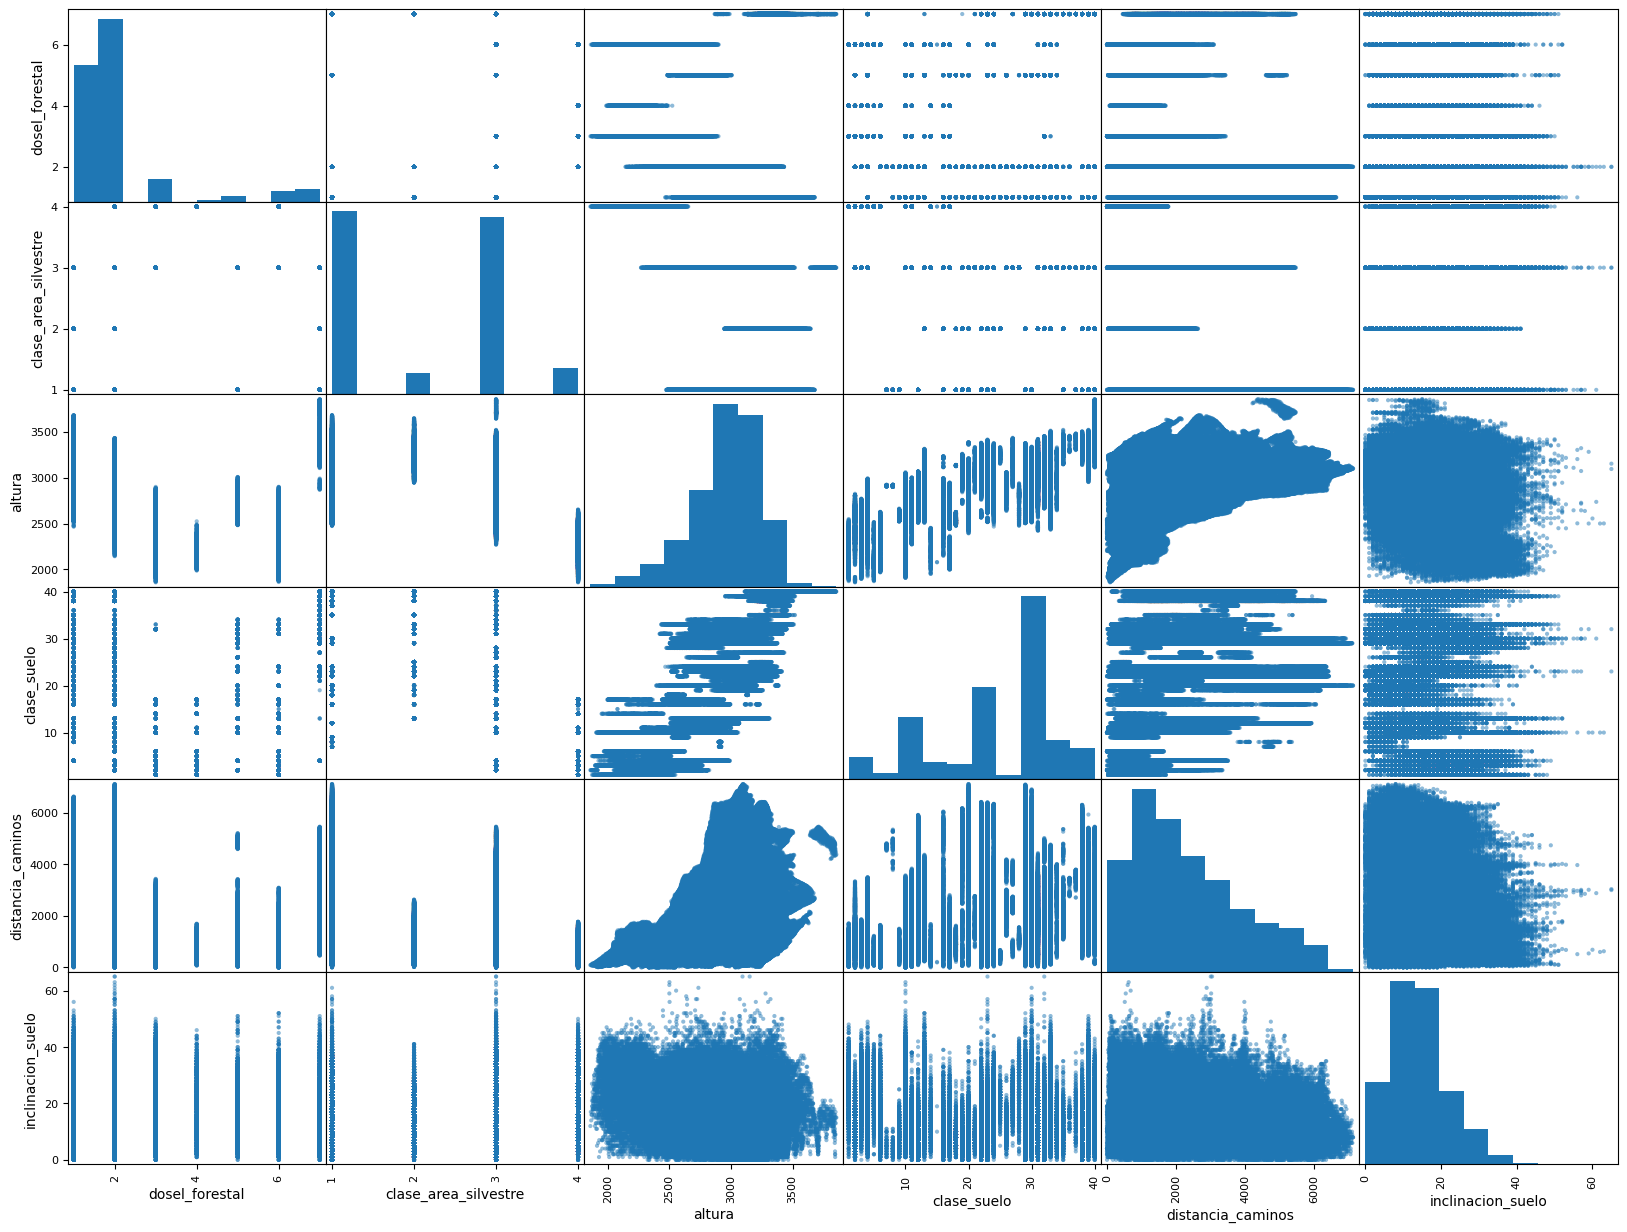

In [56]:
correlated_features = ['dosel_forestal', 'clase_area_silvestre', 'altura', 'clase_suelo', 'distancia_caminos', 'inclinacion_suelo']
pd.plotting.scatter_matrix(data[correlated_features], figsize=(20, 15));

From these I don't perceive any interesting relation with the target. There seems to be some relation between the `clase_suelo` and the `altura` features but little can be done with it as the first one is a categorical feature and the second a numerical one. 

### Combining features

##### Shade
The features regarding the shades might be useful to combine into an average, let's find out:

In [47]:
data['sombra'] = data[['sombra_maniana', 'sombra_mediodia', 'sombra_tarde']].mean(axis=1)

In [48]:
corr_matrix = data.corr()
corr_matrix['dosel_forestal'].sort_values(ascending=False)

dosel_forestal          1.000000
clase_area_silvestre    0.276797
inclinacion_suelo       0.148559
altura_agua             0.080721
exposicion              0.017218
distancia_agua         -0.021787
sombra_maniana         -0.036094
sombra_tarde           -0.048040
sombra_mediodia        -0.097080
sombra                 -0.108852
distancia_fuego        -0.108859
distancia_caminos      -0.153657
clase_suelo            -0.165768
altura                 -0.271345
Name: dosel_forestal, dtype: float64

Effectively, it gives a feature with better correlation to the target than the other 3 by their own; not a huge improvement though.

##### Classes

Maybe we could get a good result combing the two categorical features into one. The values of `clase_area_silvestre` can be expressed with one digit (in decimal) and the values of `clase_suelo` with at most two, so we could make a new label that identifies any combination of the two doing, for instance, 

$$
	\text{combinado} = 100 \times \text{clase\_area\_silvestre} + \text{clase\_suelo}
$$

In [49]:
data['combinado'] = 100 * data['clase_area_silvestre'] + data['clase_suelo']

In [50]:
corr_matrix = data.corr()
corr_matrix['dosel_forestal'].sort_values(ascending=False)

dosel_forestal          1.000000
clase_area_silvestre    0.276797
combinado               0.267486
inclinacion_suelo       0.148559
altura_agua             0.080721
exposicion              0.017218
distancia_agua         -0.021787
sombra_maniana         -0.036094
sombra_tarde           -0.048040
sombra_mediodia        -0.097080
sombra                 -0.108852
distancia_fuego        -0.108859
distancia_caminos      -0.153657
clase_suelo            -0.165768
altura                 -0.271345
Name: dosel_forestal, dtype: float64

The combined feature has a very good correlation, but it comes form the `clase_area_silvestre` as multiplying bu 100 doesn't change the relation it has with the target; the addition of `clase_suelo` (at least in the way it was done) just adds noise and worsens the correlation.

In [51]:
data.drop('combinado', axis=1, inplace=True)

### One-hot encoding

Maybe some categories of the categorical data ara more correlated to the target than the others. Let's apply a one-hot encoding to them and see how it turns out

In [52]:
clase_area_silvestre_one_hot_encoded = pd.get_dummies(data['clase_area_silvestre'], prefix='clase_area_silvestre')
newdata = pd.concat([data, clase_area_silvestre_one_hot_encoded], axis=1)

In [53]:
corr_matrix = newdata.corr()
corr_matrix['dosel_forestal'].sort_values(ascending=False)

dosel_forestal            1.000000
clase_area_silvestre_4    0.323614
clase_area_silvestre      0.276797
inclinacion_suelo         0.148559
altura_agua               0.080721
clase_area_silvestre_3    0.068009
exposicion                0.017218
distancia_agua           -0.021787
sombra_maniana           -0.036094
sombra_tarde             -0.048040
clase_area_silvestre_2   -0.048639
sombra_mediodia          -0.097080
sombra                   -0.108852
distancia_fuego          -0.108859
distancia_caminos        -0.153657
clase_suelo              -0.165768
clase_area_silvestre_1   -0.205098
altura                   -0.271345
Name: dosel_forestal, dtype: float64

NICE!! Wether a row belong to the category `4` of the `clase_area_silvestre` or not seems to be very important in the result, giving us an even bigger correlation than the original feature itself. `clase_area_silvestre_1` has also a big correlation with our target.

Let's now do the same with the other categorical feature. In this case there are 40 categories, so I'll just keep the ~5 better ones and keep the original column 

In [54]:
clase_suelo_one_hot_encoded = pd.get_dummies(data['clase_suelo'], prefix='clase_suelo')
newdata = pd.concat([newdata, clase_suelo_one_hot_encoded], axis=1)

In [55]:
corr_matrix = newdata.corr()
corr_matrix['dosel_forestal'].sort_values(ascending=False)

dosel_forestal            1.000000
clase_area_silvestre_4    0.323614
clase_area_silvestre      0.276797
clase_suelo_10            0.246015
clase_suelo_39            0.157334
clase_suelo_38            0.156558
inclinacion_suelo         0.148559
clase_suelo_40            0.125992
clase_suelo_2             0.117036
clase_suelo_6             0.112667
clase_suelo_4             0.099584
clase_suelo_17            0.091044
clase_suelo_1             0.090402
altura_agua               0.080721
clase_suelo_37            0.080617
clase_suelo_35            0.078711
clase_suelo_5             0.076553
clase_suelo_3             0.069065
clase_area_silvestre_3    0.068009
clase_suelo_14            0.066127
clase_suelo_11            0.035201
clase_suelo_36            0.029309
clase_suelo_13            0.024475
exposicion                0.017218
clase_suelo_16            0.011959
clase_suelo_18            0.006956
clase_suelo_15            0.006564
clase_suelo_34            0.005245
clase_suelo_7       

As in the previous case there is one category that is way more correlated to that target then the original categorical feature and many are better than other original features. I'll just keep the categories `10`, `39` and `38` and drop the rest while keeping the original column.

In [56]:
# I'll encode this entirely so I'll drop the original
data.drop('clase_area_silvestre', axis=1, inplace=True)

data = pd.concat([data, clase_area_silvestre_one_hot_encoded, clase_suelo_one_hot_encoded[['clase_suelo_10', 'clase_suelo_39', 'clase_suelo_38']]], axis=1)

In [57]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 371848 entries, 388024 to 451283
Data columns (total 20 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   altura                  371848 non-null  int64  
 1   exposicion              371848 non-null  int64  
 2   inclinacion_suelo       371848 non-null  int64  
 3   distancia_agua          371848 non-null  int64  
 4   altura_agua             371848 non-null  int64  
 5   distancia_caminos       371848 non-null  int64  
 6   sombra_maniana          371848 non-null  int64  
 7   sombra_mediodia         371848 non-null  int64  
 8   sombra_tarde            371848 non-null  int64  
 9   distancia_fuego         371848 non-null  int64  
 10  clase_suelo             371848 non-null  int64  
 11  dosel_forestal          371848 non-null  int64  
 12  sombra                  371848 non-null  float64
 13  clase_area_silvestre_1  371848 non-null  uint8  
 14  clase_area_silv

In [58]:
corr_matrix = data.corr()
corr_matrix['dosel_forestal'].sort_values(ascending=False)

dosel_forestal            1.000000
clase_area_silvestre_4    0.323614
clase_suelo_10            0.246015
clase_suelo_39            0.157334
clase_suelo_38            0.156558
inclinacion_suelo         0.148559
altura_agua               0.080721
clase_area_silvestre_3    0.068009
exposicion                0.017218
distancia_agua           -0.021787
sombra_maniana           -0.036094
sombra_tarde             -0.048040
clase_area_silvestre_2   -0.048639
sombra_mediodia          -0.097080
sombra                   -0.108852
distancia_fuego          -0.108859
distancia_caminos        -0.153657
clase_suelo              -0.165768
clase_area_silvestre_1   -0.205098
altura                   -0.271345
Name: dosel_forestal, dtype: float64

With these manipulations we ended up with some new features that are more correlated with the target than the ones we had the be beginning, so well done.

### Export and leave

I can't find anything else interesting over here, so I'll export the training data and star with the ML

In [59]:
data.to_pickle(os.path.join(DATA_SUBDIR, 'train.pkl'))